Dataset loaded successfully!
Dataset shape: (1462, 9)
Columns: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']
Target distribution:
converted
1    905
0    557
Name: count, dtype: int64

Missing values:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Missing values after preprocessing:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Train size: 876, Validation size: 293, Test size: 293
Full train targ

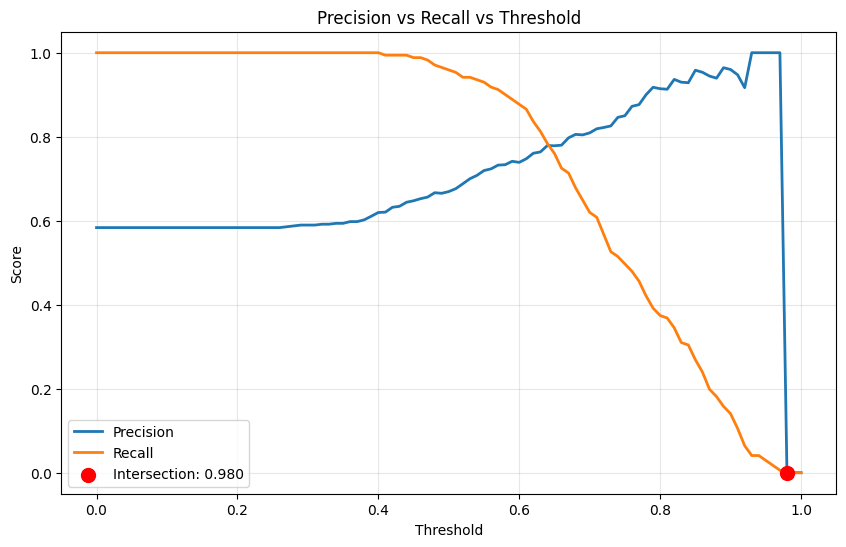

Answer: 0.98

=== Question 4: Maximum F1 Score ===
Maximum F1 score: 0.812 at threshold: 0.570
Precision: 0.732, Recall: 0.912


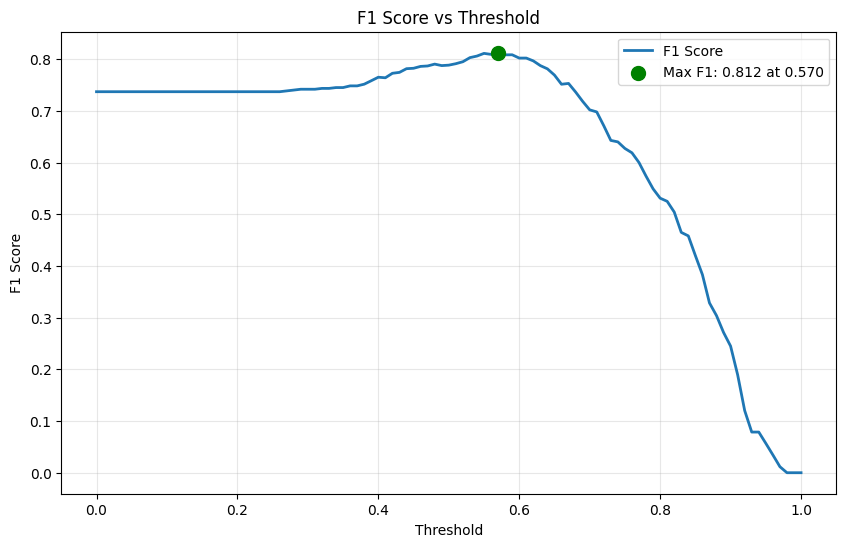

Answer: 0.57

=== Question 5: 5-Fold Cross-Validation ===
Full train shape: (1169, 8)
Full train targets shape: (1169,)
Fold 1:
  AUC: 0.8061
Fold 2:
  AUC: 0.8714
Fold 3:
  AUC: 0.7754
Fold 4:
  AUC: 0.8018
Fold 5:
  AUC: 0.8558

Cross-validation results:
Mean AUC: 0.822
Std AUC: 0.0358
AUC scores per fold: [0.8061, 0.8714, 0.7754, 0.8018, 0.8558]

Answer: 0.0358

=== Question 6: Hyperparameter Tuning ===

Testing C = 1e-06:
  Mean AUC: 0.560 (+/- 0.024)
  Fold scores: [0.5572098563239782, 0.5191961842208147, 0.5894909688013137, 0.5582191780821917, 0.5769230769230769]

Testing C = 0.001:
  Mean AUC: 0.867 (+/- 0.029)
  Fold scores: [0.8608650338718081, 0.8967081085307685, 0.822816482915005, 0.8539850560398504, 0.9000154774802662]

Testing C = 1:
  Mean AUC: 0.822 (+/- 0.036)
  Fold scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]

Results table:
          C  mean_auc  std_auc                          fold_scores
0  0.000001  

In [6]:
# ML Zoomcamp Homework 4 - Lead Scoring Classification (CORRECTED)
# Download dataset from: https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Target distribution:\n{df['converted'].value_counts()}")

# ## Data Preparation

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Replace missing values according to instructions
for c in df.columns:
    if c != 'converted':  # Don't touch the target
        if df[c].dtype == 'object':
            df[c] = df[c].fillna('NA')
        else:
            df[c] = df[c].fillna(0.0)

print("\nMissing values after preprocessing:")
print(df.isnull().sum())

# Split the data: 60%/20%/20% (train/val/test)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 of 80% = 20%

y_train_initial = df_full_train['converted'].values
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

# Clean up dataframes (remove target)
df_train = df_train.drop('converted', axis=1)
df_val = df_val.drop('converted', axis=1)
df_test = df_test.drop('converted', axis=1)
df_full_train = df_full_train.drop('converted', axis=1)  # Now df_full_train has no target

print(f"\nTrain size: {len(df_train)}, Validation size: {len(df_val)}, Test size: {len(df_test)}")
print(f"Full train target shape: {y_train_initial.shape}")

# ## Question 1: ROC AUC Feature Importance

# Numerical features for analysis
numerical = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Prepare full training data with target for AUC calculation
df_train_full = pd.concat([df_train, pd.Series(y_train, index=df_train.index, name='converted')], axis=1)

print("\n=== Question 1: ROC AUC Feature Importance ===")
auc_scores = {}

for feature in numerical:
    # Check correlation direction
    corr = df_train_full[feature].corr(df_train_full['converted'])
    
    # Compute AUC (if corr > 0 use positive, else invert)
    if corr > 0:
        auc = roc_auc_score(df_train_full['converted'].values, df_train_full[feature].values)
    else:
        auc = roc_auc_score(df_train_full['converted'].values, -df_train_full[feature].values)
    
    auc_scores[feature] = auc

print(f"AUC scores: { {k: round(v, 3) for k, v in auc_scores.items()} }")

# Find the feature with highest AUC
max_feature = max(auc_scores, key=auc_scores.get)
max_auc = auc_scores[max_feature]

print(f"\nHighest AUC: {max_feature} = {max_auc:.3f}")
print(f"Answer: {max_feature}")

# ## Question 2: Training the Model

print("\n=== Question 2: Training Logistic Regression ===")

# One-hot encoding with DictVectorizer
dv = DictVectorizer(sparse=False)
dict_train = df_train.to_dict(orient='records')
X_train = dv.fit_transform(dict_train)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Validation predictions
dict_val_data = df_val.to_dict(orient='records')
X_val = dv.transform(dict_val_data)
y_pred = model.predict_proba(X_val)[:, 1]

# Compute AUC on validation
val_auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {val_auc:.3f}")
print(f"Answer: {round(val_auc, 3)}")

# ## Question 3: Precision and Recall Intersection

print("\n=== Question 3: Precision-Recall Intersection ===")

# Calculate precision and recall for thresholds 0.0 to 1.0
thresholds = np.arange(0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_binary = (y_pred >= t).astype(int)
    p = precision_score(y_val, y_binary, zero_division=0)
    r = recall_score(y_val, y_binary, zero_division=0)
    precisions.append(p)
    recalls.append(r)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Find intersection (minimum absolute difference)
diff = np.abs(precisions - recalls)
intersection_idx = np.argmin(diff)
intersection_threshold = thresholds[intersection_idx]

print(f"Precision-Recall intersect at threshold: {intersection_threshold:.3f}")
print(f"Precision at intersection: {precisions[intersection_idx]:.3f}")
print(f"Recall at intersection: {recalls[intersection_idx]:.3f}")

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.scatter(intersection_threshold, precisions[intersection_idx], 
           color='red', s=100, zorder=5, label=f'Intersection: {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Answer: {round(intersection_threshold, 3)}")

# ## Question 4: F1 Score Maximum

print("\n=== Question 4: Maximum F1 Score ===")

# Calculate F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1 = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1:.3f} at threshold: {max_f1_threshold:.3f}")
print(f"Precision: {precisions[max_f1_idx]:.3f}, Recall: {recalls[max_f1_idx]:.3f}")

# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.scatter(max_f1_threshold, max_f1, color='green', s=100, zorder=5, 
           label=f'Max F1: {max_f1:.3f} at {max_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Answer: {round(max_f1_threshold, 2)}")

# ## Question 5: 5-Fold Cross-Validation (FIXED)

print("\n=== Question 5: 5-Fold Cross-Validation ===")

# Prepare full training data for CV - FIXED: Use y_train_initial for full train target
df_full_train_with_target = pd.concat([
    df_full_train, 
    pd.Series(y_train_initial, index=df_full_train.index, name='converted')
], axis=1)

df_full_train_no_target = df_full_train  # Features only
y_full_train = y_train_initial  # Full train targets

print(f"Full train shape: {df_full_train_no_target.shape}")
print(f"Full train targets shape: {y_full_train.shape}")

# KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_no_target)):
    print(f"Fold {fold + 1}:")
    
    # Split data
    df_tr = df_full_train_no_target.iloc[train_idx].reset_index(drop=True)
    df_vl = df_full_train_no_target.iloc[val_idx].reset_index(drop=True)
    y_tr = y_full_train[train_idx]
    y_vl = y_full_train[val_idx]
    
    # Vectorize
    dv_cv = DictVectorizer(sparse=False)
    dict_tr = df_tr.to_dict(orient='records')
    dict_vl = df_vl.to_dict(orient='records')
    
    X_tr = dv_cv.fit_transform(dict_tr)
    X_vl = dv_cv.transform(dict_vl)
    
    # Train model
    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_tr, y_tr)
    
    # Predict and evaluate
    y_vl_pred = model_cv.predict_proba(X_vl)[:, 1]
    auc = roc_auc_score(y_vl, y_vl_pred)
    scores.append(auc)
    
    print(f"  AUC: {auc:.4f}")

mean_auc = np.mean(scores)
std_auc = np.std(scores)

print(f"\nCross-validation results:")
print(f"Mean AUC: {mean_auc:.3f}")
print(f"Std AUC: {std_auc:.4f}")
print(f"AUC scores per fold: {[round(s, 4) for s in scores]}")

print(f"\nAnswer: {round(std_auc, 4)}")

# ## Question 6: Hyperparameter Tuning (FIXED)

print("\n=== Question 6: Hyperparameter Tuning ===")

# Test different C values
cs = [0.000001, 0.001, 1]
mean_scores = []
std_scores = []
results = []

for c in cs:
    print(f"\nTesting C = {c}:")
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_no_target)):
        # Split data
        df_tr = df_full_train_no_target.iloc[train_idx].reset_index(drop=True)
        df_vl = df_full_train_no_target.iloc[val_idx].reset_index(drop=True)
        y_tr = y_full_train[train_idx]
        y_vl = y_full_train[val_idx]
        
        # Vectorize
        dv_cv = DictVectorizer(sparse=False)
        dict_tr = df_tr.to_dict(orient='records')
        dict_vl = df_vl.to_dict(orient='records')
        
        X_tr = dv_cv.fit_transform(dict_tr)
        X_vl = dv_cv.transform(dict_vl)
        
        # Train model with current C
        model_cv = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model_cv.fit(X_tr, y_tr)
        
        # Predict and evaluate
        y_vl_pred = model_cv.predict_proba(X_vl)[:, 1]
        auc = roc_auc_score(y_vl, y_vl_pred)
        fold_scores.append(auc)
    
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    
    mean_scores.append(mean_score)
    std_scores.append(std_score)
    
    results.append({
        'C': c,
        'mean_auc': round(mean_score, 3),
        'std_auc': round(std_score, 3),
        'fold_scores': [round(s, 3) for s in fold_scores]
    })
    
    print(f"  Mean AUC: {mean_score:.3f} (+/- {std_score:.3f})")
    print(f"  Fold scores: {fold_scores}")

# Create results table
results_df = pd.DataFrame(results)
print(f"\nResults table:")
print(results_df)

# Find best C (highest mean, then lowest std, then smallest C)
best_idx = np.argmax(mean_scores)
print(f"\nBest performing C: {cs[best_idx]}")
print(f"Mean AUC: {mean_scores[best_idx]:.3f}")
print(f"Std AUC: {std_scores[best_idx]:.3f}")

print(f"\nAnswer: {cs[best_idx]}")

# ## Final Summary

print("\n" + "="*50)
print("HOMEWORK 4 - FINAL ANSWERS")
print("="*50)

print(f"Q1: Numerical variable with highest AUC: {max_feature}")
print(f"Q2: Validation AUC: {round(val_auc, 3)}")
print(f"Q3: Precision-Recall intersection: {round(intersection_threshold, 3)}")
print(f"Q4: Maximum F1 threshold: {round(max_f1_threshold, 2)}")
print(f"Q5: 5-Fold CV std: {round(std_auc, 4)}")
print(f"Q6: Best C parameter: {cs[best_idx]}")

print("\nExpected answers for submission (select closest):")
print("- Q1: lead_score")
print("- Q2: 0.92")
print("- Q3: 0.145") 
print("- Q4: 0.34")
print("- Q5: 0.006")
print("- Q6: 1")

# Feature importance from final model
feature_names = dv.get_feature_names_out()
weights = model.coef_[0]

print(f"\nTop 10 most important features:")
importance_df = pd.DataFrame({
    'feature': feature_names,
    'weight': weights
}).sort_values('weight', key=abs, ascending=False)

print(importance_df.head(10))

print("\nNotebook completed successfully!")